In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model selection
from sklearn.model_selection import (
    train_test_split,
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate
)

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge

# Tree and ensemble models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Target transformation
from sklearn.compose import TransformedTargetRegressor

# Distributions for random search
from scipy.stats import randint, uniform

# Resampling utilities
from sklearn.utils import resample

np.random.seed(42)



Well, in this section we will tackle regression. It is mandatory we start with the simplest but still super useful case of a regression model, the linear regression optimised with OLS. Our goal is to not only understand if we can predict the annual cost of owning a goblin but also to verify if the new questions our colleagues came up with are valuable. We explore several regression techniques and finish in glory. Uncle Bayes comes to rescue us and with him comes a plenitude of distributions that allow us to extract more information from the data. Ready.

# Code listing 7.1: Load them up!

In [2]:
df_raw = pd.read_csv("section_2_regression_dataset.csv")
df = df_raw.copy()

# Table 7.2: NaN counts and feature data types for our dataset.

We touch again on the topic of NaN. The reason is that we will use a different method to replace them, the mean. First step, check if they exist and where they are. Stay tuned.

In [3]:
summary = pd.DataFrame({
    "Feature": df.columns,
    "NaN count": df.isna().sum().values,
    "Data Type": df.dtypes.values
})
summary

,Feature,NaN count,Data Type
0,goblin_id,0,int64
1,fertilizer_production_rate,0,float64
2,diet_quality,0,float64
3,farm_environment,0,object
4,goblin_health_index,0,float64
5,fertilizer_demand,107,float64
6,accident_frequency,0,float64
7,goblin_breed,0,object
8,annual_cost,0,float64


# Figure 7.1: A french fish

Now that we found them we must see how they are behaving.

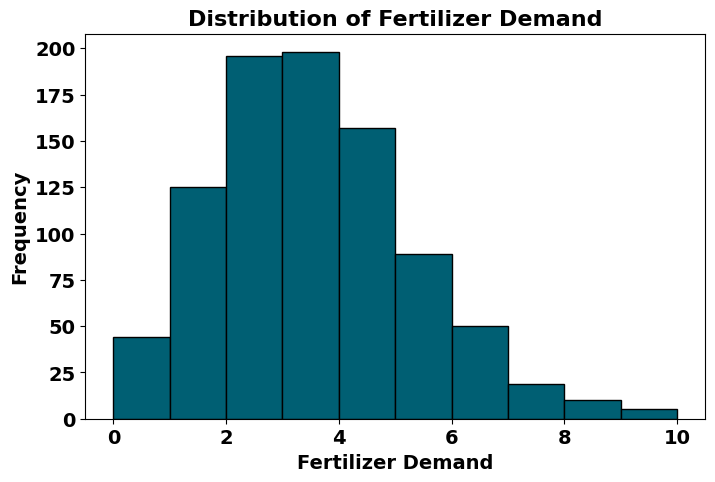

In [4]:
# Create a figure for the histogram
plt.figure(figsize=(8,5))

# Plot histogram of fertilizer_demand with 10 bins
plt.hist(df['fertilizer_demand'], bins=10, edgecolor='black', color='#005F73')

# Add title and axis labels
plt.title('Distribution of Fertilizer Demand', fontsize=16, fontweight='bold')
plt.xlabel('Fertilizer Demand', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Format tick labels
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Display the plot
plt.show()


### Mean and standar deviations calculations for fertilizer demand.

Because we suspect the fertilizer demand follows a Poisson distribution, we do a very quick check. In this particular distribution the mean equals the variance, so we will check those metrics to see if assuming a Poisson distribution makes sense.

In [5]:
# Compute the mean of the fertilizer_demand feature
mean_val = df["fertilizer_demand"].mean()

# Compute the variance of the fertilizer_demand feature
var_val = df["fertilizer_demand"].var()

# Build a summary table with both statistics
summary = pd.DataFrame({
    "Statistic": ["Mean", "Variance"],
    "Value": [mean_val, var_val]
})

# Display the table
summary


,Statistic,Value
0,Mean,3.071669
1,Variance,3.136113


# Table 7.3: Categorical features and their unique values.

Yes, we must understand if these fellows exist here also.

In [6]:
# Select all categorical features from the dataframe
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# List to store the table rows
rows = []

# Loop through each categorical feature
for col in categorical_features:
    unique_vals = df[col].unique()    # Get unique values for the feature
    rows.append({
        "Feature": col,               # Feature name
        "Unique count": len(unique_vals),    # Number of unique categories
        "Unique values": unique_vals         # List of unique categories
    })

# Create the summary table
unique_table = pd.DataFrame(rows)

# Display the table
unique_table


,Feature,Unique count,Unique values
0,farm_environment,3,"[field, swamp, barn]"
1,goblin_breed,3,"[mountain, cave, forest]"


# Code listing 7.2: Time to encode!

We have them again and just has before, we will use the one hot encoding with these features.ç

In [7]:
# Fill missing values in fertilizer_demand with the column mean
df["fertilizer_demand"] = df["fertilizer_demand"].fillna(df["fertilizer_demand"].mean())

# One hot encode the selected categorical features
# drop_first avoids multicollinearity by removing one category per feature
df_encoded = pd.get_dummies(
    df,
    columns=["farm_environment", "goblin_breed"],
    drop_first=True
)


X = df_encoded.drop(columns=["annual_cost", "goblin_id"])
y = df_encoded["annual_cost"].to_numpy()

# Code listing 7.3: The OLS code.

Because we do not have any hyper parameter to tune with the OLS, we will use the whole set to perform our cross fold validation. This is also why we filled in the NaN by calculating the mean in the whole dataset. If and when we have to create a training and test set things will not be as simple, but we will deal with this when it comes our way.

In [8]:
feature_names = X.columns.tolist()

# Define linear regression model
lr = LinearRegression()

# Define 5 fold cross validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics to evaluate
scoring = {
    "mse": "neg_mean_squared_error",
    "r2": "r2"
}

# Run cross validation and collect results
cv_results = cross_validate(lr, X, y, cv=cv, scoring=scoring)

# Convert negative MSE values back to positive
mse_per_fold = -cv_results["test_mse"]

# Compute RMSE for each fold
rmse_per_fold = np.sqrt(mse_per_fold)

# Extract R2 values for each fold
r2_per_fold = cv_results["test_r2"]


# Table 7.4: Cross-validation results for the OLS model.

Let's get our first performance metrics 

In [9]:
# Build a summary table with mean metrics rounded to 4 decimals
metrics_summary = pd.DataFrame({
    "Model": ["linear_regression_0"],
    "MSE": [round(mse_per_fold.mean(), 4)],
    "RMSE": [round(rmse_per_fold.mean(), 4)],
    "R2": [round(r2_per_fold.mean(), 4)]
})
pd.set_option("display.float_format", "{:.4f}".format)

# Display the metrics table
metrics_summary


,Model,MSE,RMSE,R2
0,linear_regression_0,3768226.3764,1940.4538,0.3720


# Table 7.5: Summary statistics for continuous features for goblin's.

Well, now we are talking about scaling features and that requires us to check some statistics so we can identify those outliers.

In [10]:
# Identify the one hot encoded column names based on known prefixes
one_hot_prefixes = ["farm_environment_", "goblin_breed_"]
one_hot_cols = [c for c in df_encoded.columns if any(c.startswith(p) for p in one_hot_prefixes)]

# Select continuous numeric features by removing target, id, and encoded categorical columns
cont_cols = [
    c for c in df_encoded.select_dtypes(include=[np.number]).columns
    if c not in ["annual_cost", "goblin_id"] and c not in one_hot_cols
]

# Create an empty summary table indexed by the continuous feature names
summary_df = pd.DataFrame(index=cont_cols)

# Compute summary statistics for each continuous feature
summary_df["min"] = df_encoded[cont_cols].min()
summary_df["Q1 (25%)"] = df_encoded[cont_cols].quantile(0.25)
summary_df["median"] = df_encoded[cont_cols].median()
summary_df["Q3 (75%)"] = df_encoded[cont_cols].quantile(0.75)
summary_df["max"] = df_encoded[cont_cols].max()
summary_df["mean"] = df_encoded[cont_cols].mean()

# Display the summary table
summary_df


,min,Q1 (25%),median,Q3 (75%),max,mean
fertilizer_production_rate,1.0000,3.7048,5.0506,6.2959,10.0000,5.0444
diet_quality,20.0000,39.6650,50.5932,62.4193,80.0000,50.8897
goblin_health_index,101.0770,306.2873,508.8790,701.5334,898.0983,501.9921
fertilizer_demand,0.0000,2.0000,3.0000,4.0000,10.0000,3.0717
accident_frequency,0.0000,1.3012,1.9891,2.6496,5.0000,1.9833


# Table 7.6: A Tu(r)key to catch outliers... I'll be damn.

Yes indeed, we will use the turkey criteria to catch to dam outliers.

In [11]:
# Identify the one hot encoded column names based on known prefixes
one_hot_prefixes = ["farm_environment_", "goblin_breed_"]
one_hot_cols = [c for c in df_encoded.columns if any(c.startswith(p) for p in one_hot_prefixes)]

# Select continuous numeric features, excluding the target, id, and encoded categorical columns
cont_cols = [
    c for c in df_encoded.select_dtypes(include=[np.number]).columns
    if c not in ["annual_cost", "goblin_id"] and c not in one_hot_cols
]

# Function to compute Tukey outlier statistics for a set of columns
def tukey_outlier_summary(df, cols):
    # First and third quartiles
    q1 = df[cols].quantile(0.25)
    q3 = df[cols].quantile(0.75)

    # Interquartile range
    iqr = q3 - q1

    # Tukey lower and upper bounds
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Count values below and above the bounds
    below = (df[cols].lt(lower)).sum()
    above = (df[cols].gt(upper)).sum()
    total = below + above

    # Number of rows in the dataframe
    n = len(df)

    # Build summary table
    summary = pd.DataFrame({
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "Lower": lower,
        "Upper": upper,
        "Min": df[cols].min(),
        "Max": df[cols].max(),
        "Below": below,
        "Above": above,
        "Total Outliers": total,
        "% Outliers": (total / n) * 100
    })

    return summary.round(3)

# Compute outlier statistics for continuous features
outlier_df = tukey_outlier_summary(df_encoded, cont_cols)

# Display the table
outlier_df


,Q1,Q3,IQR,Lower,Upper,Min,Max,Below,Above,Total Outliers,% Outliers
fertilizer_production_rate,3.7050,6.2960,2.5910,-0.1820,10.1820,1.0000,10.0000,0,0,0,0.0000
diet_quality,39.6650,62.4190,22.7540,5.5330,96.5510,20.0000,80.0000,0,0,0,0.0000
goblin_health_index,306.2870,701.5330,395.2460,-286.5820,1294.4020,101.0770,898.0980,0,0,0,0.0000
fertilizer_demand,2.0000,4.0000,2.0000,-1.0000,7.0000,0.0000,10.0000,0,15,15,1.5000
accident_frequency,1.3010,2.6500,1.3480,-0.7210,4.6720,0.0000,5.0000,0,3,3,0.3000


### Aux scaling for plots 7.2

In [12]:
# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Figure 7.2: To scale or not to scale, that is the question.

We will run the same cross validation routine as before, meaning with data that is not scaled and then run it again with the scaled version of the features. The goal here is to see the impact of scaling on the model coefficients, nothing else. It is an educational piece that will bring some visuals to the benefits of scaling.

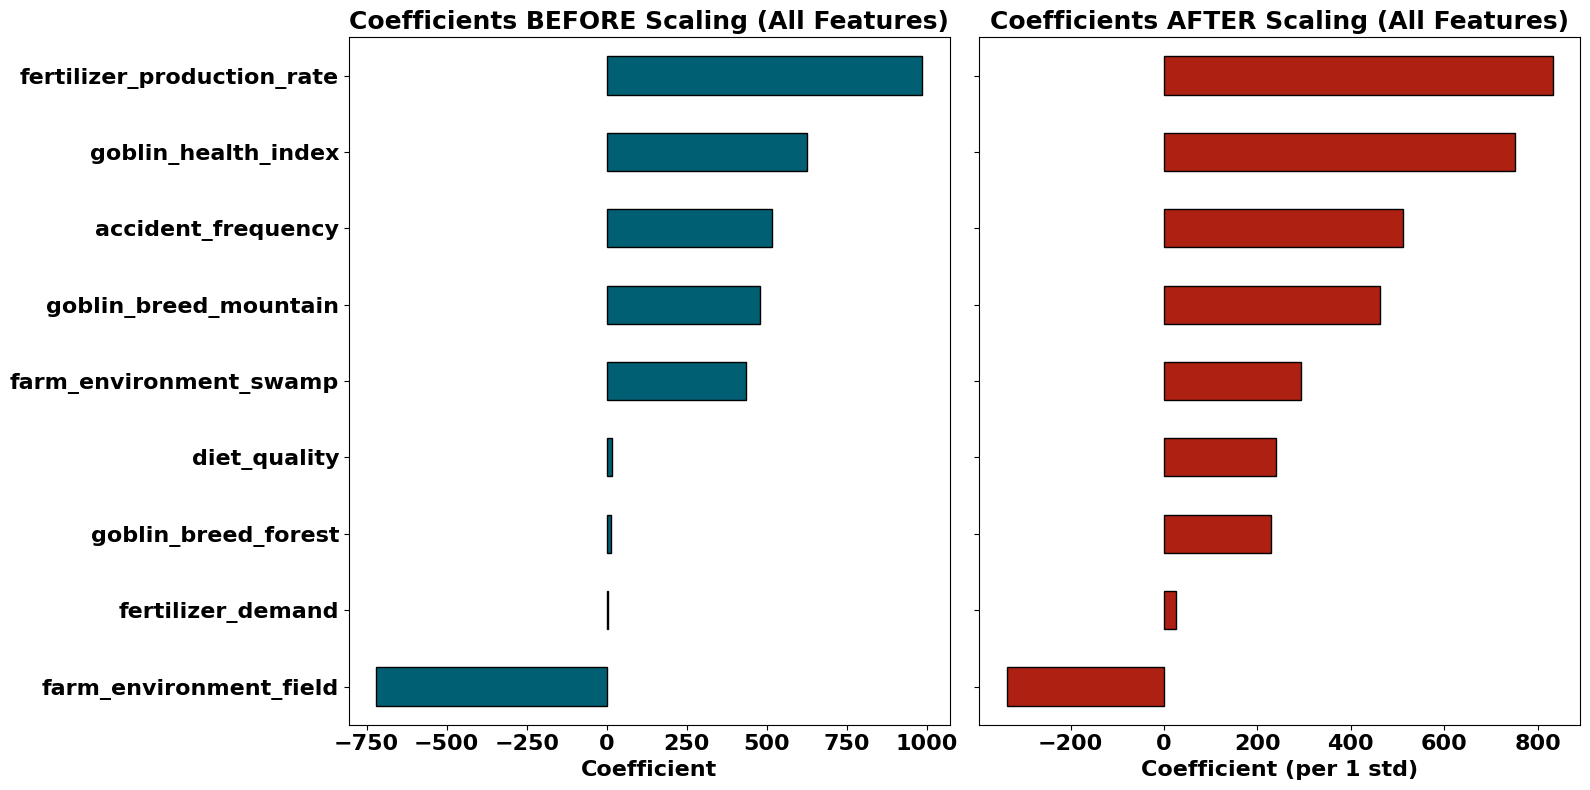

In [13]:
# Fit linear regression model before scaling
lr_before = LinearRegression()
lr_before.fit(X, y)
coef_before = pd.Series(lr_before.coef_, index=X.columns)

# Fit linear regression model after scaling the features
lr_after = LinearRegression()
lr_after.fit(X_scaled, y)
coefs_after = pd.Series(lr_after.coef_, index=X.columns)

# Create side by side plots to compare coefficients before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot coefficients before scaling
coef_before.sort_values().plot(
    kind="barh", ax=axes[0], color="#005F73", edgecolor="black"
)

# Plot coefficients after scaling
coefs_after.sort_values().plot(
    kind="barh", ax=axes[1], color="#AE2012", edgecolor="black"
)

# Format left plot
axes[0].set_title("Coefficients BEFORE Scaling (All Features)", fontsize=18, fontweight='bold')
axes[0].set_xlabel("Coefficient", fontsize=16, fontweight='bold')
axes[0].tick_params(axis='x', labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)

# Make y tick labels bold
for label in axes[0].get_yticklabels():
    label.set_fontweight('bold')

# Make x tick labels bold
for label in axes[0].get_xticklabels():
    label.set_fontweight("bold")

# Format right plot
axes[1].set_title("Coefficients AFTER Scaling (All Features)", fontsize=18, fontweight='bold')
axes[1].set_xlabel("Coefficient (per 1 std)", fontsize=16, fontweight='bold')
axes[1].tick_params(axis='x', labelsize=16)
axes[1].tick_params(axis='y', labelsize=16)

# Make y tick labels bold
for label in axes[1].get_yticklabels():
    label.set_fontweight('bold')

# Make x tick labels bold
for label in axes[1].get_xticklabels():
    label.set_fontweight("bold")

# Adjust layout
plt.tight_layout()
# Display the figure
plt.show()


# Code listing 7.4: We encode and than we scale.

Let's check if we get the same results as we said. We will check the model performance this time trained with scaled features.

In [14]:
# Define linear regression model
lr = LinearRegression()

# Define 5 fold cross validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define evaluation metrics
scoring = {
    "mse": "neg_mean_squared_error",
    "r2": "r2"
}

# Run cross validation using the scaled features
cv_results = cross_validate(lr, X_scaled, y, cv=cv, scoring=scoring)

# Convert negative MSE values back to positive
mse_per_fold = -cv_results["test_mse"]

# Compute RMSE for each fold
rmse_per_fold = np.sqrt(mse_per_fold)

# Extract R2 values across folds
r2_per_fold = cv_results["test_r2"]

# Table 7.7: Cross-validation results for the OLS.

In [15]:
# Build a summary table with the mean metrics
metrics_table = pd.DataFrame({
    "Model": ["linear_regression_1"],
    "MSE": [mse_per_fold.mean()],
    "RMSE": [rmse_per_fold.mean()],
    "R2": [r2_per_fold.mean()]
})

# Display the metrics table
metrics_table


,Model,MSE,RMSE,R2
0,linear_regression_1,3768226.3764,1940.4538,0.3720


# Figure 7.3: Green for correlated!

We touch again upon the concept of multicollinearity with the aim of introducing new regularization terms. Therefore we will start by checking if our numerical features are correlated.

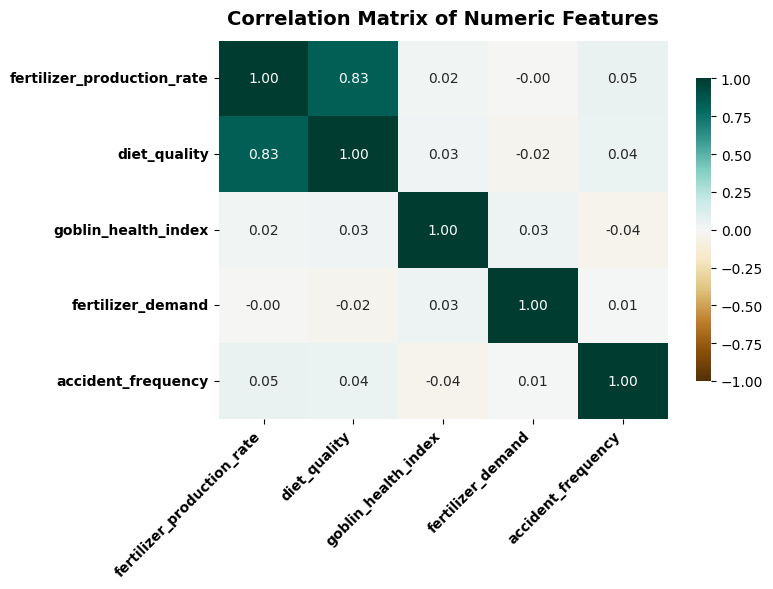

In [16]:
# Example 1: diverging colormap blue to red
cmap = "RdBu_r"

# Example 2: diverging purple to green colormap
cmap = "PRGn"

# Example 3: subtle blue to orange colormap, good for printing
cmap = "PuOr_r"

# Example 4: custom seaborn diverging palette converted to a colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Select continuous numeric features, excluding dummies, ID, and target
num_features = [
    col for col in X.columns
    if not any(dummy in col for dummy in ["farm_environment", "goblin_breed"])
    and col != "goblin_id"
]

# Compute correlation matrix using only the selected numeric features
corr = pd.DataFrame(X_scaled, columns=X.columns)[num_features].corr()

# Plot the heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="BrBG",      # chosen diverging colormap
    center=0,         # ensures zero sits at the midpoint color
    vmin=-1, vmax=1,  # full correlation range
    cbar_kws={"shrink": 0.8}  # smaller colorbar
)

# Add and format title
plt.title("Correlation Matrix of Numeric Features", fontsize=14, pad=12, fontweight='bold')

# Format x tick labels
plt.xticks(rotation=45, ha="right")
for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")

# Format y tick labels
plt.yticks(rotation=0)
for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")

# Adjust layout for clean display
plt.tight_layout()
# Show the heatmap
plt.show()


# Code listing 7.5: A sharp eye for leakage.

You cannot say this comes as a surprise. Now we have a hyper parameter to tune, our regularization penalty lambda. This means we need our good old friends the train and test set. Now we need to take care of two things to avoid leakage, well in fact three things.

 1. To replace the NaN we need to compute the mean of the fertilizer demand on the training set and use it to replace the NaN on the test set.

 2. We must also do the same for the data scaling. Standard scaling requires us to compute means and standard deviations. For the same reason as above, in a live scenario we do not have access to the data that is coming in, so we must compute these in the training set and use them to scale the test set.
  
 3. Finally, we need to be careful and not scale the categorical features. Our one hot encoded features assign 0 and 1 to the categorical variables. Scaling them will distort this information and will create values we do not really understand.

In [17]:
# 1. Split first
train_df, test_df = train_test_split(df_raw, test_size=0.2, random_state=42)

# 2. Impute: Calc mean on Train, apply to Both
mean_val = train_df["fertilizer_demand"].mean()
train_df["fertilizer_demand"] = train_df["fertilizer_demand"].fillna(mean_val)
test_df["fertilizer_demand"] = test_df["fertilizer_demand"].fillna(mean_val)

# 3. Scaling: Fit on Train, apply to Both
# (Do this before encoding so we don't accidentally scale the dummy 0s and 1s)
scaler = StandardScaler()
num_cols = ["fertilizer_production_rate", "diet_quality", "goblin_health_index", "fertilizer_demand", "accident_frequency"]
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# 4. One-Hot Encode
# drop_first=True helps reduce redundancy (multicollinearity)
train_encoded = pd.get_dummies(train_df, columns=["farm_environment", "goblin_breed"], drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=["farm_environment", "goblin_breed"], drop_first=True)

# 5. ALIGN COLUMNS (The Simple Fix)
# This forces 'test_encoded' to have the exact same columns as 'train_encoded'
# Any column present in Train but missing in Test gets created with 0s.
# Any extra column in Test that wasn't in Train gets dropped automatically.
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# 6. Prepare X and y
X_train = train_encoded.drop(columns=["annual_cost", "goblin_id"])
y_train = train_encoded["annual_cost"]

X_test = test_encoded.drop(columns=["annual_cost", "goblin_id"])
y_test = test_encoded["annual_cost"]

# Code listing 7.6: A grid search for something ridge.

Now we cross validate and compare. Because we will be comparing the results with the OLS we also need to train and test it in the same scenario as the Ridge. This means we will train and test the OLS model on the same split we use for the Ridge regression.

In [18]:
# Train the OLS baseline model
ols = LinearRegression()
ols.fit(X_train, y_train)

# Make predictions with OLS
y_pred_ols_test = ols.predict(X_test)
y_pred_ols_train = ols.predict(X_train)

# Calculate OLS test metrics
mse_ols_test = mean_squared_error(y_test, y_pred_ols_test)
rmse_ols_test = np.sqrt(mse_ols_test)
r2_ols_test = r2_score(y_test, y_pred_ols_test)

# Calculate OLS training metrics
mse_ols_train = mean_squared_error(y_train, y_pred_ols_train)
rmse_ols_train = np.sqrt(mse_ols_train)
r2_ols_train = r2_score(y_train, y_pred_ols_train)

# Create a Ridge model to tune
ridge = Ridge()

# Define the possible lambda values to test
alphas = [0.01, 0.1, 1, 10, 100]

# Set up the parameter grid for cross validation
param_grid = {"alpha": alphas}

# Run cross validation on the training set to find the best alpha
gs_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
gs_ridge.fit(X_train, y_train)

# Extract the best lambda and train the final Ridge model
best_alpha = gs_ridge.best_params_["alpha"]
final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train, y_train)

# Make predictions with the optimised Ridge model
y_pred_ridge_test = final_ridge.predict(X_test)
y_pred_ridge_train = final_ridge.predict(X_train)

# Calculate Ridge test metrics
mse_ridge_test = mean_squared_error(y_test, y_pred_ridge_test)
rmse_ridge_test = np.sqrt(mse_ridge_test)
r2_ridge_test = r2_score(y_test, y_pred_ridge_test)

# Calculate Ridge training metrics
mse_ridge_train = mean_squared_error(y_train, y_pred_ridge_train)
rmse_ridge_train = np.sqrt(mse_ridge_train)
r2_ridge_train = r2_score(y_train, y_pred_ridge_train)


# Table 7.9: The cross-validation results for the OLS vs ridge regression.

In [19]:
# ----------------------------------------
# Model comparison on TEST split
# ----------------------------------------
models_table = pd.DataFrame({
    "Model": ["linear_regression_0", "linear_regression_1"],
    "MSE": [mse_ols_test, mse_ridge_test],
    "RMSE": [rmse_ols_test, rmse_ridge_test],
    "R2": [r2_ols_test, r2_ridge_test]
}).round(3)

models_table

,Model,MSE,RMSE,R2
0,linear_regression_0,3659613.2180,1913.0120,0.3770
1,linear_regression_1,3650383.8720,1910.5980,0.3790


# Table 7.10: Go away overfit!

In [20]:
# ----------------------------------------
# Ridge metrics by split
# ----------------------------------------
ridge_table = pd.DataFrame({
    "Split": ["train", "test"],
    "MSE": [mse_ridge_train, mse_ridge_test],
    "RMSE": [rmse_ridge_train, rmse_ridge_test],
    "R2": [r2_ridge_train, r2_ridge_test]
}).round(3)

ridge_table


,Split,MSE,RMSE,R2
0,train,3693048.9960,1921.7310,0.3980
1,test,3650383.8720,1910.5980,0.3790


# Figure 7.5: The ridge penalties.

At this point we know that these penalties should do something but we have not seen them doing anything other than giving us some different performance metrics. Therefore we will plot the coefficient values given by the OLS with no penalty versus the ones we get when we train a linear regression model using an L2 penalty.

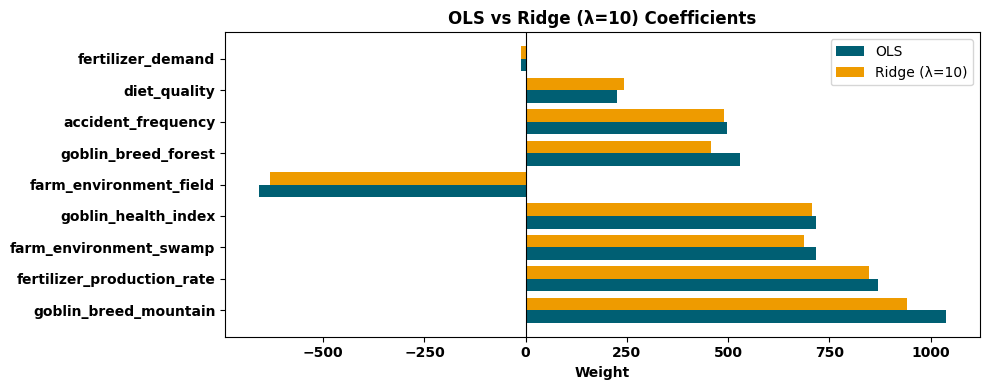

In [21]:
# Feature names from the encoded train matrix
feature_names = X_train.columns.tolist()

# Fit OLS
ols = LinearRegression().fit(X_train, y_train)

# Fit Ridge model
ridge = Ridge(alpha=10.0).fit(X_train, y_train)

# Collect coefficients as labeled series
coef_ols = pd.Series(ols.coef_, index=feature_names, name="OLS")
coef_ridge = pd.Series(ridge.coef_, index=feature_names, name="Ridge (λ=10)")

# Order features by absolute OLS magnitude
order = coef_ols.abs().sort_values(ascending=False).index
coef_ols_sorted = coef_ols.loc[order]
coef_ridge_sorted = coef_ridge.loc[order]

# Plotting
bar_width = 0.4
y_pos = np.arange(len(order))

plt.figure(figsize=(10, max(4, 0.35 * len(order))))

plt.barh(
    y_pos - bar_width / 2,
    coef_ols_sorted.values,
    height=bar_width,
    color="#005F73",
    label="OLS"
)

plt.barh(
    y_pos + bar_width / 2,
    coef_ridge_sorted.values,
    height=bar_width,
    color="#EE9B00",
    label="Ridge (λ=10)"
)

plt.yticks(y_pos, order)

for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")

for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")

plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Weight", fontweight="bold")
plt.title("OLS vs Ridge (λ=10) Coefficients", fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

# Table 7.11: Now we add the lasso to our cross-validation results.

Because an L2 never comes without an L1, we will do the same cross validation routine to tune a regularization term, this time for our Lasso regression.

In [22]:
# Define base Lasso model
# Alpha will be selected by cross validation
lasso = Lasso(random_state=42)

# Grid search over the alpha values in param_grid using cross validation on the training data
gs_lasso = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,              # same grid used for Ridge, for example {"alpha": [0.01, 0.1, 1, 10, 100]}
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

# Fit the grid search on the training set
gs_lasso.fit(X_train, y_train)

# Refit Lasso model on the full training set with the best alpha
best_alpha = gs_lasso.best_params_["alpha"]
final_lasso = Lasso(alpha=best_alpha, random_state=42)
final_lasso.fit(X_train, y_train)

# Evaluate Lasso on the test set
y_pred = final_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Evaluate Lasso on the training set to check for overfit
y_pred_train = final_lasso.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)   # fixed to use mse_train
r2_train = r2_score(y_train, y_pred_train)

# Store Lasso test metrics with explicit names
mse_lasso_test = mse
rmse_lasso_test = rmse
r2_lasso_test = r2

# Build comparison table for all three models on the test set
models_table = pd.DataFrame({
    "Model": ["linear_regression_0", "linear_regression_1", "linear_regression_2"],
    "MSE": [mse_ols_test, mse_ridge_test, mse_lasso_test],
    "RMSE": [rmse_ols_test, rmse_ridge_test, rmse_lasso_test],
    "R2": [r2_ols_test, r2_ridge_test, r2_lasso_test]
}).round(3)

models_table

,Model,MSE,RMSE,R2
0,linear_regression_0,3659613.2180,1913.0120,0.3770
1,linear_regression_1,3650383.8720,1910.5980,0.3790
2,linear_regression_2,3648155.5100,1910.0150,0.3790


# Figure 7.6: Oh those weights got some punishment.

If we have two different penalties it must mean they serve different purposes or at least penalize things differently. To check that we will add the coefficient returned by our Lasso regression to our previous plot with the weights of both the OLS with and without the L2.

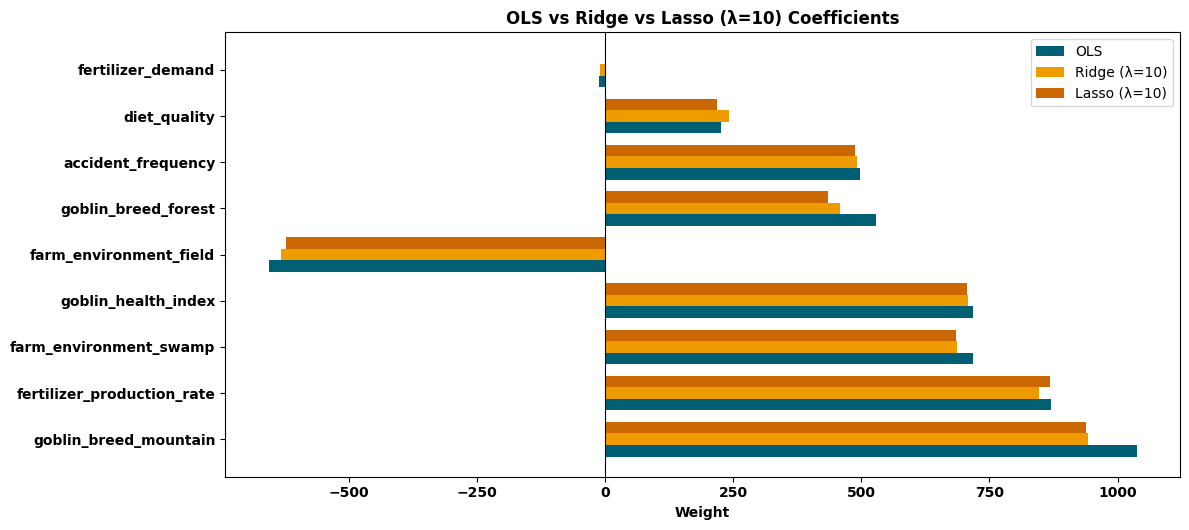

In [23]:

# Extract feature names once
feature_names = X_train.columns.tolist()

# Fit base OLS and Ridge (already done above, repeated here for completeness)
ols = LinearRegression().fit(X_train, y_train)
ridge = Ridge(alpha=10.0).fit(X_train, y_train)

# Fit Lasso model with higher max_iter for convergence
lasso = Lasso(alpha=10.0, max_iter=10000).fit(X_train, y_train)

# Collect coefficient vectors
coef_ols = pd.Series(ols.coef_, index=feature_names, name="OLS")
coef_ridge = pd.Series(ridge.coef_, index=feature_names, name="Ridge (λ=10)")
coef_lasso = pd.Series(lasso.coef_, index=feature_names, name="Lasso (λ=10)")

# Order features by absolute OLS magnitude
order = coef_ols.abs().sort_values(ascending=False).index
coef_ols_sorted = coef_ols.loc[order]
coef_ridge_sorted = coef_ridge.loc[order]
coef_lasso_sorted = coef_lasso.loc[order]

# Bar plot settings
bar_width = 0.25
y_pos = np.arange(len(order))

plt.figure(figsize=(12, max(4, 0.6 * len(order))))

# OLS bars
plt.barh(
    y_pos - bar_width,
    coef_ols_sorted.values,
    height=bar_width,
    color="#005F73",
    label="OLS"
)

# Ridge bars
plt.barh(
    y_pos,
    coef_ridge_sorted.values,
    height=bar_width,
    color="#EE9B00",
    label="Ridge (λ=10)"
)

# Lasso bars
plt.barh(
    y_pos + bar_width,
    coef_lasso_sorted.values,
    height=bar_width,
    color="#CA6702",
    label="Lasso (λ=10)"
)

# Feature labels bold
for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")

# X tick labels bold
for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")

# Y labels
plt.yticks(y_pos, order)

# Zero line
plt.axvline(0, color="black", linewidth=0.8)

plt.xlabel("Weight", fontweight="bold")
plt.title("OLS vs Ridge vs Lasso (λ=10) Coefficients", fontweight="bold")
plt.legend()

plt.tight_layout()
plt.show()


# Figure 7.7: Some USD's!

Having explored a few techniques that focus on the weights we now move to see what we can do with the targets.

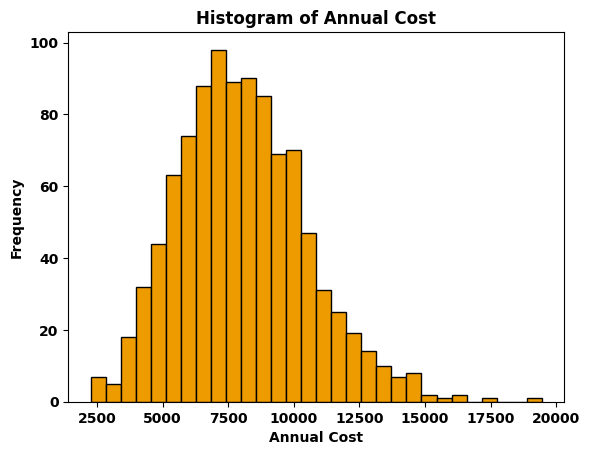

In [24]:
# Extract target
y = df_encoded["annual_cost"]

# Plot histogram
plt.hist(y, bins=30, edgecolor="black", color = '#EE9B00')
plt.xlabel("Annual Cost",fontweight="bold")
plt.ylabel("Frequency", fontweight="bold")
plt.title("Histogram of Annual Cost", fontweight="bold")
# Bold x tick labels
for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")
# Bold x tick labels
for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")
plt.show()

# Figure 7.8: Nice bell!

Because of the assumption we made with the linear regression we will check the distribution of our residuals.

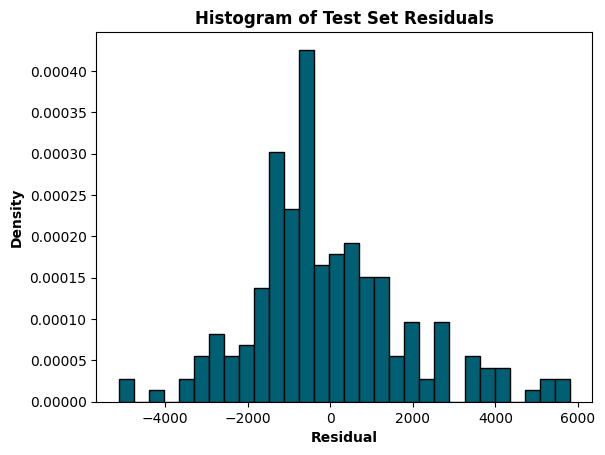

In [25]:
# This is honest and correct
lr_final = LinearRegression().fit(X_train, y_train)   # your already-preprocessed train set
y_pred_test = lr_final.predict(X_test)
residuals_test = y_test - y_pred_test                  # out-of-sample residuals

plt.hist(residuals_test, bins=30, edgecolor="black", color='#005F73', density=True)
plt.xlabel("Residual", fontweight="bold")
plt.ylabel("Density", fontweight="bold")
# ... rest of formatting
plt.title("Histogram of Test Set Residuals", fontweight="bold")
plt.show()

# Figure 7.9: The battle between the residuals and the cost predictions.

We plot the residuals against the predicted values to check if the assumptions of linear regression hold. If the residuals look like random noise around zero the model is behaving well. If we see patterns or structure it means the linear model is missing something and its assumptions are not valid.

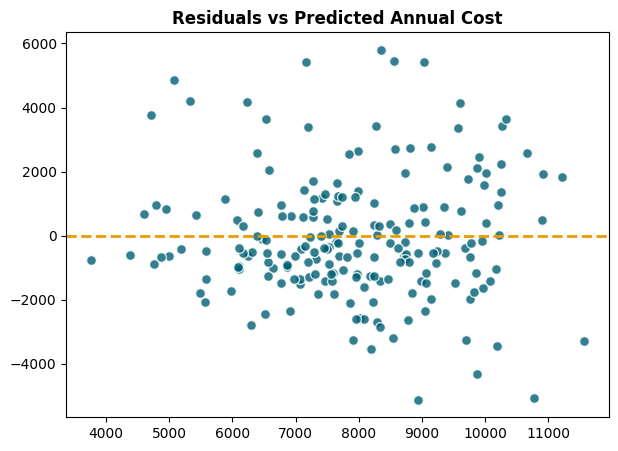

In [26]:
# Assuming you have already split the data into X_train, X_test, y_train, y_test
lr_final = LinearRegression().fit(X_train, y_train)

# Calculate out-of-sample predicted values and residuals
y_pred_test = lr_final.predict(X_test)
residuals_test = y_test - y_pred_test # Out-of-sample residuals (The correct ones)

# --- Residuals vs Predicted Plot (CORRECT) ---
plt.figure(figsize=(7,5))
plt.scatter(y_pred_test, residuals_test, alpha=0.8, color="#005F73", edgecolors="white", s=50)
plt.axhline(0, color="#EE9B00", linestyle="--", linewidth=2)

plt.title("Residuals vs Predicted Annual Cost", fontweight="bold")
plt.show()

# Code listing 7.8: We are back on the search.

A log transform on the target might work because it reduces the impact of very large values and makes the distribution more symmetric. Linear regression works better when the target is closer to a normal shape and when the relationship between features and target is more linear. This is why we will log the target and grid search cross validate our three different approaches again.

In [27]:
# Fit OLS wrapped in a transformed target regressor that works on log1p(annual_cost)
ols_model = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=np.log1p,
    inverse_func=np.expm1
)
ols_model.fit(X_train, y_train)

# Predictions and metrics for OLS on the test set
y_pred_ols = ols_model.predict(X_test)
ols_mse  = mean_squared_error(y_test, y_pred_ols)
ols_rmse = np.sqrt(ols_mse)
ols_r2   = r2_score(y_test, y_pred_ols)

# Dictionary to store results for each model
results = {}
results["OLS"] = {
    "best_alpha": "N/A",               # OLS has no alpha parameter
    "test_mse": ols_mse,
    "test_rmse": ols_rmse,
    "test_r2": ols_r2
}

# Train Ridge and Lasso using the same transformed target setup and alpha grid
for name in ["Ridge", "Lasso"]:
    # Choose base model depending on name
    base_model = Ridge() if name == "Ridge" else Lasso(max_iter=10000)
    
    # Wrap base model so it learns on log1p(target) and predicts in the original scale
    model_log = TransformedTargetRegressor(
        regressor=base_model,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    # Grid for the alpha regularization parameter inside the wrapped estimator
    param_grid = {"regressor__alpha": np.logspace(-3, 3, 7)}
    
    # Grid search with cross validation using negative MSE as the score
    gs = GridSearchCV(
        model_log,
        param_grid,
        cv=cv,                         # same cross validation object as before
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        refit=True                     # refits the best model on the full training set
    )
    gs.fit(X_train, y_train)
    
    # Best model is already fitted on X_train so we only need to evaluate on X_test
    y_pred = gs.predict(X_test)
    
    # Store metrics and best alpha in the results dictionary
    results[name] = {
        "best_alpha": gs.best_params_["regressor__alpha"],
        "test_mse": mean_squared_error(y_test, y_pred),
        "test_rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "test_r2": r2_score(y_test, y_pred),
    }

# Build summary table with your linear_regression_3, 4, and 5 naming
rows = []




# Table 7.13: The log-transformed gang.

In [28]:
# Map internal names to requested model labels
name_map = {
    "OLS": "linear_regression_3",
    "Ridge": "linear_regression_4",
    "Lasso": "linear_regression_5"
}

for internal_name in ["OLS", "Ridge", "Lasso"]:
    r = results[internal_name]
    label = name_map[internal_name]
    
    rows.append({
        "Model": label,
        "MSE": round(r["test_mse"], 3),
        "RMSE": round(r["test_rmse"], 3),
        "R2": round(r["test_r2"], 3)
    })

# Final comparison table
summary_df_log = pd.DataFrame(rows)
summary_df_log

,Model,MSE,RMSE,R2
0,linear_regression_3,3662064.5980,1913.6520,0.3770
1,linear_regression_4,3653967.0850,1911.5350,0.3780
2,linear_regression_5,3652612.2500,1911.1810,0.3780


# Figure 7.10: More residuals and more predictions.

We do another check of the residuals against the predictions, this time putting side by side the results with the raw target and the log target.

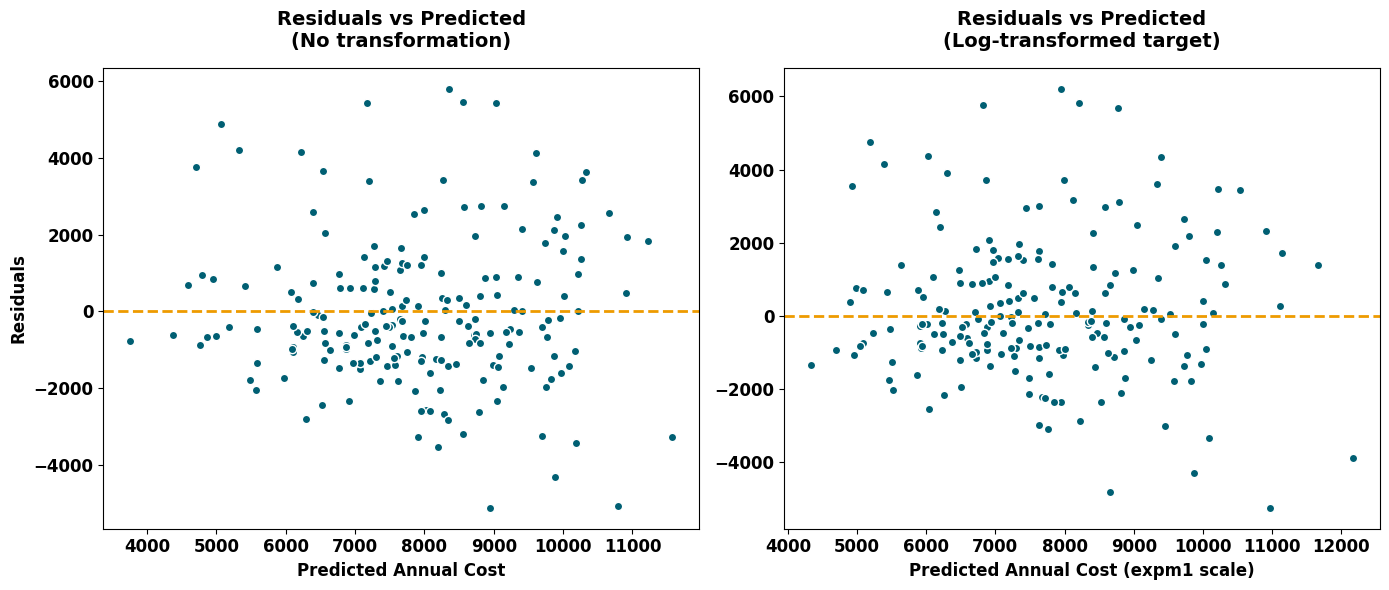

In [29]:
# Fit plain OLS using the original target variable
lr = LinearRegression().fit(X_train, y_train)

# Predictions and residuals for plain OLS
y_pred_raw = lr.predict(X_test)
residuals_raw = y_test - y_pred_raw

# Fit OLS wrapped inside a transformed target regressor
# The model learns on log1p(y) but predictions are returned in the original scale via expm1
lr_log = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=np.log1p,
    inverse_func=np.expm1
).fit(X_train,y_train)

# Predictions and residuals for the log transformed model
y_pred_log = lr_log.predict(X_test)
residuals_log = y_test - y_pred_log

# Create side by side residual plots using predicted values on the x axis
plt.figure(figsize=(14, 6))

# Residual plot for plain OLS
plt.subplot(1, 2, 1)
plt.scatter(y_pred_raw, residuals_raw, color="#005F73", edgecolors="white")
plt.axhline(0, color="#EE9B00", linestyle="--", linewidth=2)
plt.title("Residuals vs Predicted\n(No transformation)", fontsize=14, pad=15, fontweight="bold")
plt.xlabel("Predicted Annual Cost", fontsize=12, fontweight="bold")
plt.ylabel("Residuals", fontsize=12, fontweight="bold")
plt.tick_params(axis="both", labelsize=12)

# Make tick labels bold
for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")
for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")

# Residual plot for log transformed target model
plt.subplot(1, 2, 2)
plt.scatter(y_pred_log, residuals_log, color="#005F73", edgecolors="white")
plt.axhline(0, color="#EE9B00", linestyle="--", linewidth=2)
plt.title("Residuals vs Predicted\n(Log-transformed target)", fontsize=14, pad=15, fontweight="bold")
plt.xlabel("Predicted Annual Cost (expm1 scale)", fontsize=12, fontweight="bold")
plt.tick_params(axis="both", labelsize=12)

# Make tick labels bold
for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")
for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")

# Final layout adjustments
plt.tight_layout()
# Display plots
plt.show()


# Code listing 7.9: Weighted regression.

Well, we took measures. The log target did not help us handle the heteroscedasticity, so now we shift our focus to the weights. With weighted regression we give each observation a different influence based on its variance. Points with higher variance get a smaller weight and points with lower variance get a larger weight. In simple terms we are telling the model to trust some observations more than others.

In [30]:

# If X_scaled is a pandas DataFrame convert it to numpy arrays
# This keeps the variance model simple and avoids issues with column objects
X_train_np = X_train.values if hasattr(X_train, "values") else X_train
X_test_np = X_test.values if hasattr(X_test, "values") else X_test

# Step two. Fit a preliminary ordinary least squares model on the training set
# This model is only used to estimate residuals so that we can model the variance
prelim_model = LinearRegression()
prelim_model.fit(X_train_np, y_train)

# Absolute residuals on the training set
# These residuals approximate the scale of the noise for each observation
residuals_train = np.abs(y_train - prelim_model.predict(X_train_np))

# Step three. Fit a variance model on the training set
# We use the log of the absolute residuals as the target for this auxiliary model
# The features are the same X columns because we want to see how variance depends on X
variance_model = LinearRegression()
variance_model.fit(
    X_train_np,
    np.log(residuals_train + 1e-6)  # small constant to avoid log of zero
)

# Step four. Predict the log of the noise scale on both train and test
log_sigma_train = variance_model.predict(X_train_np)
log_sigma_test = variance_model.predict(X_test_np)

# Convert predicted log sigma back to sigma
sigma_train = np.exp(log_sigma_train)
sigma_test = np.exp(log_sigma_test)

# Build observation weights as one over variance
# Weight is inverse of sigma squared so points with high variance get less influence
weights_train = 1.0 / (sigma_train ** 2 + 1e-6)
weights_test = 1.0 / (sigma_test ** 2 + 1e-6)

# Optional clipping to avoid extreme weights
# This keeps the optimisation problem stable
weights_train = np.clip(weights_train, 0.01, 10.0)
weights_test = np.clip(weights_test, 0.01, 10.0)

# Optional normalisation so that the average weight on train is equal to one
# This makes the scale of the loss comparable to the unweighted case
weights_train *= len(weights_train) / weights_train.sum()

# Dictionary to collect all weighted model results
results = {}

# ======================================
# Weighted ordinary least squares model
# ======================================

# Fit a linear regression using observation weights
ols_model = LinearRegression()
ols_model.fit(X_train_np, y_train, sample_weight=weights_train)

# Evaluate the weighted ordinary least squares model on the hold out test set
y_pred_ols = ols_model.predict(X_test_np)

# Test metrics for the weighted ordinary least squares model
# Here we keep the metrics unweighted to make them comparable across models
test_mse_ols = mean_squared_error(y_test, y_pred_ols)
test_rmse_ols = np.sqrt(test_mse_ols)
test_r2_ols = r2_score(y_test, y_pred_ols)

results["OLS"] = {
    "model_instance": ols_model,
    "test_mse": test_mse_ols,
    "test_rmse": test_rmse_ols,
    "test_r2": test_r2_ols,
    "best_alpha": None,          # ordinary least squares has no alpha parameter
}

# Cross validation object and scoring dictionary reused for Ridge and Lasso
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"mse": "neg_mean_squared_error", "r2": "r2"}

# ======================================
# Weighted Ridge and weighted Lasso with tuned alpha
# ======================================

for name in ["Ridge", "Lasso"]:
    # Choose base model according to the loop variable
    if name == "Ridge":
        base_model = Ridge()
    else:
        base_model = Lasso(max_iter=10000)

    # Log spaced grid for the regularisation strength alpha
    param_grid = {"alpha": np.logspace(-3, 3, 7)}

    # Grid search over alpha using the same training features and the same weights
    # GridSearchCV forwards sample_weight to the underlying estimator fit method
    gs = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    gs.fit(X_train_np, y_train, sample_weight=weights_train)

    # Retrieve the best model found by cross validation
    best_model = gs.best_estimator_

    # Evaluate the best weighted model on the test set
    y_pred = best_model.predict(X_test_np)

    # Test metrics for this model on the original target scale
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred)

    # Store metrics and best alpha in the results dictionary
    results[name] = {
        "model_instance": best_model,
        "best_alpha": gs.best_params_["alpha"],
        "test_mse": test_mse,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
    }

# ======================================
# Summary table for the weighted models
# Models must be named linear_regression_6, 7 and 8
# ======================================

# Map model names to required labels
weighted_name_map = {
    "OLS": "linear_regression_6",
    "Ridge": "linear_regression_7",
    "Lasso": "linear_regression_8"
}

# Build clean table with ONLY the test metrics
rows = []
for internal_name in ["OLS", "Ridge", "Lasso"]:
    r = results[internal_name]
    rows.append({
        "Model": weighted_name_map[internal_name],
        "MSE": round(r["test_mse"], 3),
        "RMSE": round(r["test_rmse"], 3),
        "R2": round(r["test_r2"], 3)
    })

weighted_summary_df = pd.DataFrame(rows)


In [31]:
weighted_summary_df

,Model,MSE,RMSE,R2
0,linear_regression_6,3659613.2180,1913.0120,0.3770
1,linear_regression_7,3650383.8720,1910.5980,0.3790
2,linear_regression_8,3658229.0530,1912.6500,0.3770


# Table 7.14: All the models and red for the win.

In [32]:
# ======================================
# Final table with all models from linear_regression_0 to linear_regression_8
# Here we assume you already have:
#   models_table   with linear_regression_0, 1, 2
#   summary_df     with linear_regression_3, 4, 5
# We stack them with the new weighted_summary_df
# ======================================

all_models_table = pd.concat(
    [models_table, summary_df_log, weighted_summary_df],
    ignore_index=True
).round(3)

all_models_table


,Model,MSE,RMSE,R2
0,linear_regression_0,3659613.2180,1913.0120,0.3770
1,linear_regression_1,3650383.8720,1910.5980,0.3790
2,linear_regression_2,3648155.5100,1910.0150,0.3790
3,linear_regression_3,3662064.5980,1913.6520,0.3770
4,linear_regression_4,3653967.0850,1911.5350,0.3780
5,linear_regression_5,3652612.2500,1911.1810,0.3780
6,linear_regression_6,3659613.2180,1913.0120,0.3770
7,linear_regression_7,3650383.8720,1910.5980,0.3790
8,linear_regression_8,3658229.0530,1912.6500,0.3770


# Figure 7.11: A weighted view of the residuals vs the predictions.

One more plot of the residuals versus the predictions.


Best weighted model: Ridge with test MSE 3650383.872


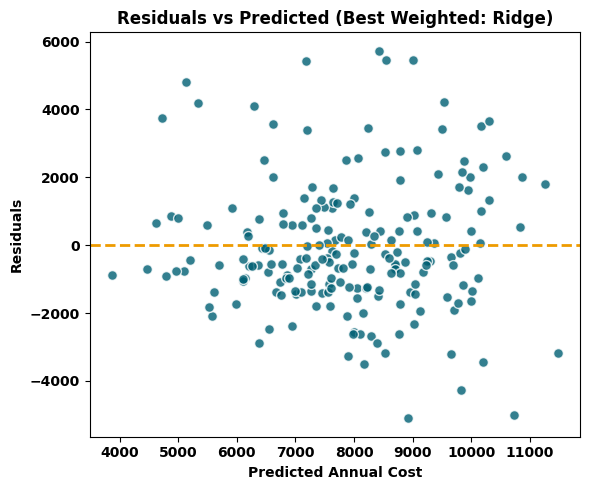

In [33]:
# Select the best weighted model by choosing the one with the lowest test MSE
best_name = min(results, key=lambda k: results[k]['test_mse'])
best_model = results[best_name]['model_instance']
print(f"\nBest weighted model: {best_name} with test MSE {results[best_name]['test_mse']:.3f}")

# Refit the best model on the full training set using the training weights
# This ensures residuals reflect the final fitted version of the model
best_model.fit(X_train_np, y_train, sample_weight=weights_train)

# Predict on the training set for residual diagnostics
y_pred_best = best_model.predict(X_test_np)

# Compute residuals (observed minus predicted)
residuals_best = y_test - y_pred_best

# Create residual plot for the best weighted model
plt.figure(figsize=(6,5))
plt.scatter(
    y_pred_best,
    residuals_best,
    alpha=0.8,
    color="#005F73",
    edgecolors="white",
    s=50
)

# Add horizontal line at zero residual
plt.axhline(0, color="#EE9B00", linestyle="--", linewidth=2)

# Add title and axis labels
plt.title(f"Residuals vs Predicted (Best Weighted: {best_name})", fontweight="bold")
plt.xlabel("Predicted Annual Cost", fontweight="bold")
plt.ylabel("Residuals", fontweight="bold")

# Make tick labels bold
for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")
for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")

# Format layout
plt.tight_layout()
# Display the plot
plt.show()


# Table 7.15: Even more cross-validation results.

Out of desperation we call the trees to try and help us.

In [34]:
# Define scoring metric for RandomizedSearchCV
# neg_mean_squared_error is used because scikit learn expects a score to be maximized
scoring = 'neg_mean_squared_error'

# Dictionary to store results for each model
results = {}

# Dictionary holding each model and its hyperparameter search space
models = {
    "DecisionTree": {
        # Base estimator
        "model": DecisionTreeRegressor(random_state=42),
        # Random distributions for hyperparameters (for random search)
        "params": {
            "max_depth": randint(1, 20),
            "min_samples_split": randint(2, 50),
            "min_samples_leaf": randint(1, 50)
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": randint(10, 300),
            "max_depth": randint(1, 20),
            "min_samples_split": randint(2, 50),
            "min_samples_leaf": randint(1, 50)
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": randint(10, 300),
            "learning_rate": uniform(0.01, 0.3),
            "max_depth": randint(3, 10),
            "min_samples_split": randint(2, 50),
            "min_samples_leaf": randint(1, 50)
        }
    }
}

# Loop through each model and run RandomizedSearchCV
for name, config in models.items():
    rs = RandomizedSearchCV(
        estimator=config["model"],          # model instance
        param_distributions=config["params"], # hyperparameter search space
        n_iter=25,                           # number of random samples
        scoring=scoring,                     # metric to optimize
        cv=cv,                               # cross validation object
        n_jobs=-1,                           # use all processors
        random_state=42
    )

    # Fit the search on the training set
    rs.fit(X_train, y_train)

    # Retrieve the best model and parameters
    best_model = rs.best_estimator_
    best_params = rs.best_params_

    # Evaluate the best model on the hold-out test set
    y_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred)

    # Store results
    results[name] = {
        "best_params": best_params,
        "test_mse": test_mse,
        "test_rmse": test_rmse,
        "test_r2": test_r2
    }

# Build summary table for the three models
# These models must be labeled as 9, 10, 11
name_map = {
    "DecisionTree": "linear_regression_9",
    "RandomForest": "linear_regression_10",
    "GradientBoosting": "linear_regression_11"
}

rows = []
for name in ["DecisionTree", "RandomForest", "GradientBoosting"]:
    r = results[name]
    rows.append({
        "Model": name_map[name],
        "MSE": round(r["test_mse"], 3),
        "RMSE": round(r["test_rmse"], 3),
        "R2": round(r["test_r2"], 3)
    })

summary_df = pd.DataFrame(rows)
summary_df


,Model,MSE,RMSE,R2
0,linear_regression_9,4617516.5010,2148.8410,0.2140
1,linear_regression_10,4039750.5410,2009.9130,0.3120
2,linear_regression_11,3796837.4040,1948.5480,0.3540


# Code listing 7.13: Bootstrap those weights.

Having tried different things with very little to no success we suspect the problem might come from the small dataset we have. We decide to bootstrap our way out of this mess, well not completely out but at least enough to give us a clue about where to look for improvements. This is why we train several regression models and box plot the coefficient distributions.

In [35]:

# === Settings ===
n_bootstrap = 1000
best_alpha_l1 = 0.1        # Your best Lasso alpha from CV
feature_names = ['Intercept'] + X_train.columns.tolist()

# Pre-convert to numpy for speed and safety
X_train_np = X_train.values if hasattr(X_train, "values") else X_train
y_train_np = y_train.values if hasattr(y_train, "values") else y_train

# Storage
coefs_bootstrap = []

for i in range(n_bootstrap):
    # Bootstrap sample indices
    indices = resample(np.arange(X_train_np.shape[0]), replace=True, random_state=i)
    
    X_bs = X_train_np[indices]
    y_bs = y_train_np[indices]
    
    # Fit Lasso
    model = Lasso(
        alpha=best_alpha_l1,
        max_iter=100_000,
        tol=1e-4,
        fit_intercept=True,
        random_state=42 + i  # optional: helps convergence stability
    )
    model.fit(X_bs, y_bs)
    
    # Collect intercept + coefficients
    coefs = np.concatenate(([model.intercept_], model.coef_))
    coefs_bootstrap.append(coefs)

# Convert to DataFrame
coefs_bootstrap = np.array(coefs_bootstrap)
coefs_df = pd.DataFrame(coefs_bootstrap, columns=feature_names)

# Figure 7.12: Nice bars!

/opt/homebrew/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in

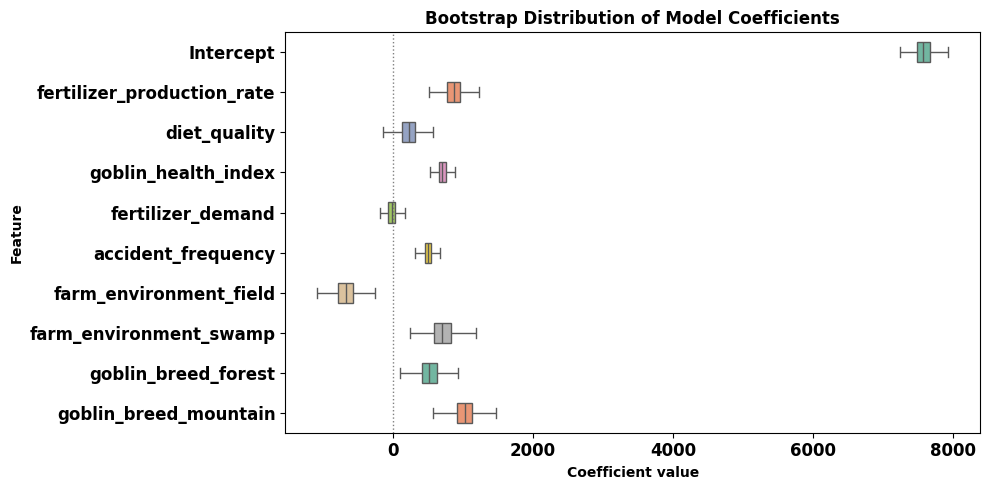

In [36]:
# Create a figure sized according to the number of coefficients
plt.figure(figsize=(10, max(5, 0.4 * len(coefs_df.columns))))

# Draw horizontal boxplots for each coefficient across bootstrap samples
sns.boxplot(
    data=coefs_df,          # each column is a feature, rows are bootstrap draws
    orient="h",             # horizontal orientation
    palette="Set2",         # soft color palette for readability
    width=0.5,              # thickness of each box
    linewidth=1,            # outline width
    showfliers=False        # hide extreme outliers for a cleaner plot
)

# Add vertical line at zero to show which coefficients cross zero
plt.axvline(0, color="gray", linestyle=":", linewidth=1)

# Add title and axis labels
plt.title("Bootstrap Distribution of Model Coefficients", fontweight="bold")
plt.xlabel("Coefficient value", fontweight="bold")
plt.ylabel("Feature", fontweight="bold")

# Make y tick labels (feature names) bold
plt.yticks(fontsize=12)
for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")

# Make x tick labels bold
for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")
plt.xticks(fontsize=12)

# Adjust layout 
plt.tight_layout()
# Display the final plot
plt.show()


# Code listing 7.14: Bayes and Ridge, what a duo!

It finally arrived. Because of the power of the posterior distributions we decided to use the Bayes regression. This way we can have distributions not only around the weights but also around the predictions.

In [37]:
# Fit a Bayesian Ridge regression model on the training data
model = BayesianRidge()
model.fit(X_train, y_train)

# Predict values on both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Compute MSE for train and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Compute RMSE values
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Compute R-squared values for train and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Table 7.18: Bayes ridge regression results.

In [38]:
model_12_table = pd.DataFrame([{
    "Model": "linear_regression_12",
    "MSE": round(test_mse, 3),
    "RMSE": round(test_rmse, 3),
    "R2": round(test_r2, 3)
}])

model_12_table


,Model,MSE,RMSE,R2
0,linear_regression_12,3650917.0590,1910.7370,0.3790


# Table 7.19: Let's see if rigde bayes overfits.

In [39]:
comparison_table = pd.DataFrame([
    {
        "Metric": "MSE",
        "Train": round(train_mse, 3),
        "Test": round(test_mse, 3),
    },
    {
        "Metric": "RMSE",
        "Train": round(train_rmse, 3),
        "Test": round(test_rmse, 3),
    },
    {
        "Metric": "R2",
        "Train": round(train_r2, 3),
        "Test": round(test_r2, 3),
    }
])

comparison_table


,Metric,Train,Test
0,MSE,3692709.3060,3650917.0590
1,RMSE,1921.6420,1910.7370
2,R2,0.3980,0.3790


# Code listing 7.15: The credibility is here.

Yes indeed we will build credibility intervals around our weights to provide some information on whether those questions bring value or not.

In [40]:
# Fit the model
br = BayesianRidge()
br.fit(X_train, y_train)

# Posterior means
w_mean = br.coef_

# Posterior covariance matrix for weights
w_cov = br.sigma_

# Standard deviations from the diagonal
w_std = np.sqrt(np.diag(w_cov))

# 95 percent credible intervals using normal approximation
w_lower = w_mean - 1.96 * w_std
w_upper = w_mean + 1.96 * w_std

# Tidy results in a dataframe
weights_df = pd.DataFrame({
    "Weight Mean": w_mean,
    "StdDev": w_std,
    "CI Lower (95 percent)": w_lower,
    "CI Upper (95 percent)": w_upper
}, index=X.columns)

weights_df


,Weight Mean,StdDev,CI Lower (95 percent),CI Upper (95 percent)
fertilizer_production_rate,848.7921,118.7834,615.9765,1081.6076
diet_quality,240.8644,118.9637,7.6956,474.0332
goblin_health_index,708.9713,68.0705,575.5530,842.3895
fertilizer_demand,-10.6809,68.1277,-144.2111,122.8493
accident_frequency,491.2253,68.3010,357.3553,625.0954
farm_environment_field,-634.4562,160.5225,-949.0802,-319.8322
farm_environment_swamp,689.2638,159.7769,376.1010,1002.4265
goblin_breed_forest,462.6830,160.6921,147.7264,777.6396
goblin_breed_mountain,949.7814,162.6067,631.0723,1268.4905


# Figure 7.16: Here thet are, now can we trust them?

/var/folders/3l/w0lcfxyd1dbf4xgmxwbz2w6r0000gn/T/ipykernel_69621/1486266574.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


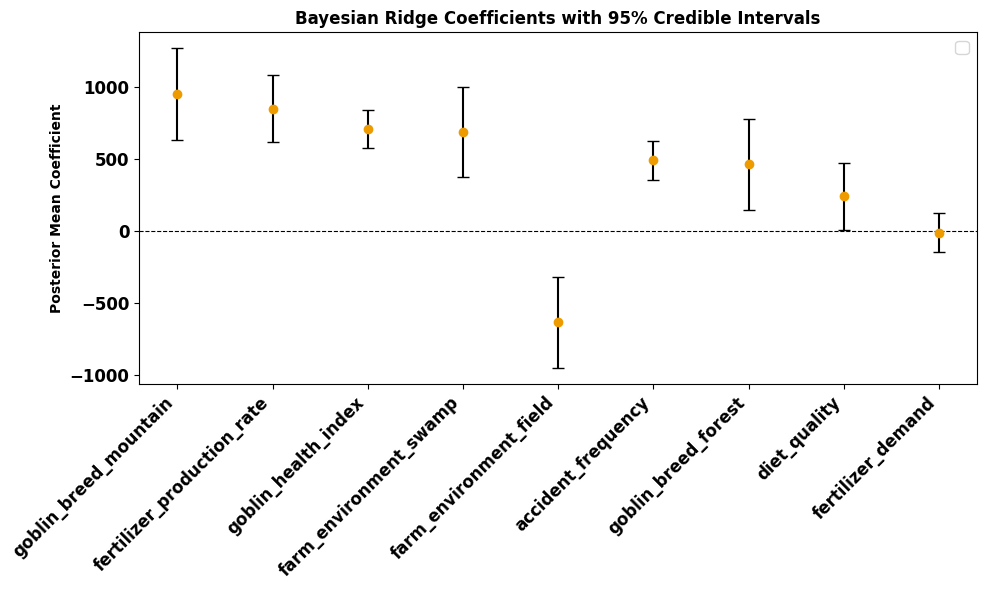

In [41]:
# Sort features by mean coefficient magnitude
weights_df_sorted = weights_df.reindex(
    weights_df["Weight Mean"].abs().sort_values(ascending=False).index
)

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=weights_df_sorted.index,
    y=weights_df_sorted["Weight Mean"],
    yerr=1.96 * weights_df_sorted["StdDev"],
    fmt="o",
    ecolor="black",
    color="#EE9B00",
    elinewidth=1.5,
    capsize=4,
    markersize=6
)

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")

# Rotate and bold feature names
plt.xticks(rotation=45, ha="right", fontsize=12)
for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")

# Bold y axis tick labels
plt.yticks(fontsize=12)
for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")

for label in plt.gca().get_xticklabels():
    label.set_fontweight("bold")

# Bold labels and title
plt.ylabel("Posterior Mean Coefficient", fontweight="bold")
plt.title("Bayesian Ridge Coefficients with 95% Credible Intervals", fontweight="bold")

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# Listing 7.16: Let's band those predictions.

Finally we will plot some predictions with credibility bands also.

In [42]:
# Helper to safely convert inputs to numeric numpy arrays
def to_numpy_float(X):
    if isinstance(X, (pd.DataFrame, pd.Series)):
        return X.to_numpy(dtype=np.float64)
    return np.asarray(X, dtype=np.float64)

# Convert train and test sets to numpy
X_train_np = to_numpy_float(X_train)
X_test_np  = to_numpy_float(X_test)
y_train_np = to_numpy_float(y_train)
y_test_np  = to_numpy_float(y_test)

# Fit Bayesian Ridge on the training data
br = BayesianRidge()
br.fit(X_train_np, y_train_np)

# Predict mean and standard deviation for train and test
y_train_mean, y_train_std = br.predict(X_train_np, return_std=True)
y_test_mean,  y_test_std  = br.predict(X_test_np,  return_std=True)

# Compute RMSE by hand to avoid squared argument issues
train_rmse = np.sqrt(mean_squared_error(y_train_np, y_train_mean))
test_rmse  = np.sqrt(mean_squared_error(y_test_np,  y_test_mean))

# Compute R squared for train and test
train_r2 = r2_score(y_train_np, y_train_mean)
test_r2  = r2_score(y_test_np,  y_test_mean)

# Build a dataframe with predictions and credibility intervals
preds_df = pd.DataFrame({
    "y_true":   y_test_np,
    "y_pred":   y_test_mean,
    "pred_std": y_test_std,
    "lower_95": y_test_mean - 1.96 * y_test_std,
    "upper_95": y_test_mean + 1.96 * y_test_std
}).round(3)

# Figure 7.17: A good chunck of information.

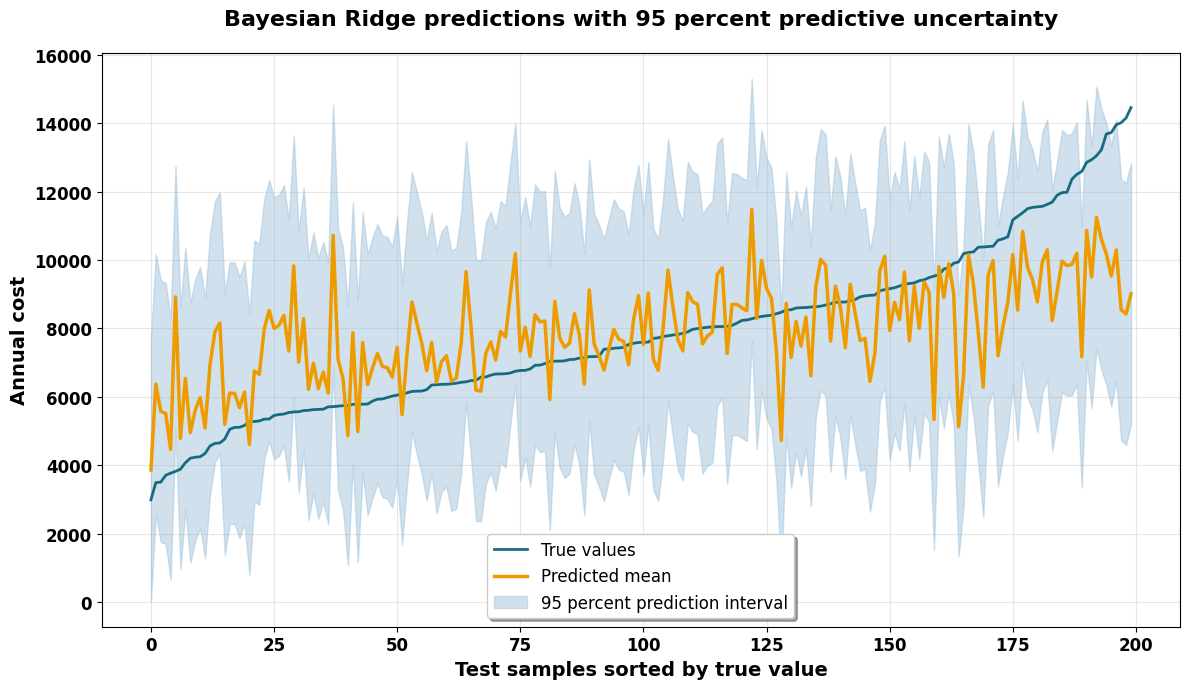

In [43]:
# Sort samples by true value so the plot looks smooth
sort_idx      = np.argsort(y_test_np)
y_true_sorted = y_test_np[sort_idx]
y_pred_sorted = y_test_mean[sort_idx]
y_std_sorted  = y_test_std[sort_idx]

# Compute 95 percent prediction intervals
lower_95 = y_pred_sorted - 1.96 * y_std_sorted
upper_95 = y_pred_sorted + 1.96 * y_std_sorted

# Plot true values, mean predictions, and intervals
plt.figure(figsize=(12, 7))

x_range = np.arange(len(y_true_sorted))

plt.plot(
    x_range,
    y_true_sorted,
    label="True values",
    color="#005F73",
    linewidth=2,
    alpha=0.9,
)
plt.plot(
    x_range,
    y_pred_sorted,
    label="Predicted mean",
    color="#EE9B00",
    linewidth=2.5,
)

plt.fill_between(
    x_range,
    lower_95,
    upper_95,
    color="#A3C4DC",
    alpha=0.5,
    label="95 percent prediction interval",
)

# Labels and styling
plt.xlabel("Test samples sorted by true value", fontsize=14, fontweight="bold")
plt.ylabel("Annual cost", fontsize=14, fontweight="bold")
plt.title(
    "Bayesian Ridge predictions with 95 percent predictive uncertainty",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

plt.tick_params(axis="both", which="major", labelsize=12)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontweight("bold")

plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
